In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import upsetplot
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [2]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [5]:
mt_df = pd.read_csv('../data/05_mastertable/26062025_PODER_mastertable.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
pops = get_population_colors()[1]
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df['det_pop'] = mt_df[get_population_colors()[1]].idxmax(axis=1)

In [8]:
# mt_df[['isoform', 'structural_category']].groupby('structural_category').nunique()

In [7]:
len(mt_df.loc[mt_df.pop_spec_t==True])

2419

In [9]:
mt_df[['isoform', 'pop_spec_t']].groupby('pop_spec_t').nunique()

,isoform
pop_spec_t,
False,153456
True,2419


In [13]:
len(mt_df.loc[(mt_df.pop_spec_t==True)&\
    (mt_df.structural_category.isin(['FSM', 'NIC', 'NNC']))].index)


2316

In [46]:
# but first, verify what my expectations are
mt_df['one_sample'] = mt_df.sample_sharing == 1
mt_df[['pop_spec_t', 'structural_category', 'one_sample']].drop_duplicates()
assert len(mt_df.loc[(mt_df.pop_spec_t==False)&\
                     (mt_df.one_sample==True)&\
                     (mt_df.structural_category!='FSM')].index) == 0

In [47]:
# divide transcripts that are not population specific into
# - not population specific, expressed in >= 2 samples and
# - sample-specific FSM

mt_df['cat'] = np.nan

# pop-spec
mt_df.loc[mt_df.pop_spec_t==True, 'cat'] = 'Population-specific'

# pop-shared
mt_df.loc[(mt_df.pop_spec_t==False)&(mt_df.sample_sharing>1), 'cat'] = 'Population-shared'

# one-sample FSMs
mt_df.loc[(mt_df.sample_sharing==1)&(mt_df.structural_category=='FSM'), 'cat'] = 'Sample-specific FSM'

assert len(mt_df.loc[mt_df.cat.isnull()]) == 0

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_40690/925175865.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Population-specific' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


In [48]:
# first, facet both by novelty and by category;
# then we can decide how to plot better
gb_cols = ['cat', 'structural_category', 'sample_sharing']
keep_cols = gb_cols + ['isoform']
temp = mt_df[keep_cols].groupby(gb_cols).nunique().rename({'isoform':'n_t'}, axis=1).reset_index()

In [49]:
mt_df[['isoform', 'cat']].groupby('cat').nunique()


,isoform
cat,
Population-shared,125239
Population-specific,2419
Sample-specific FSM,28217


In [50]:
c_dict, order = get_novelty_colors(mt_df.structural_category.unique().tolist())

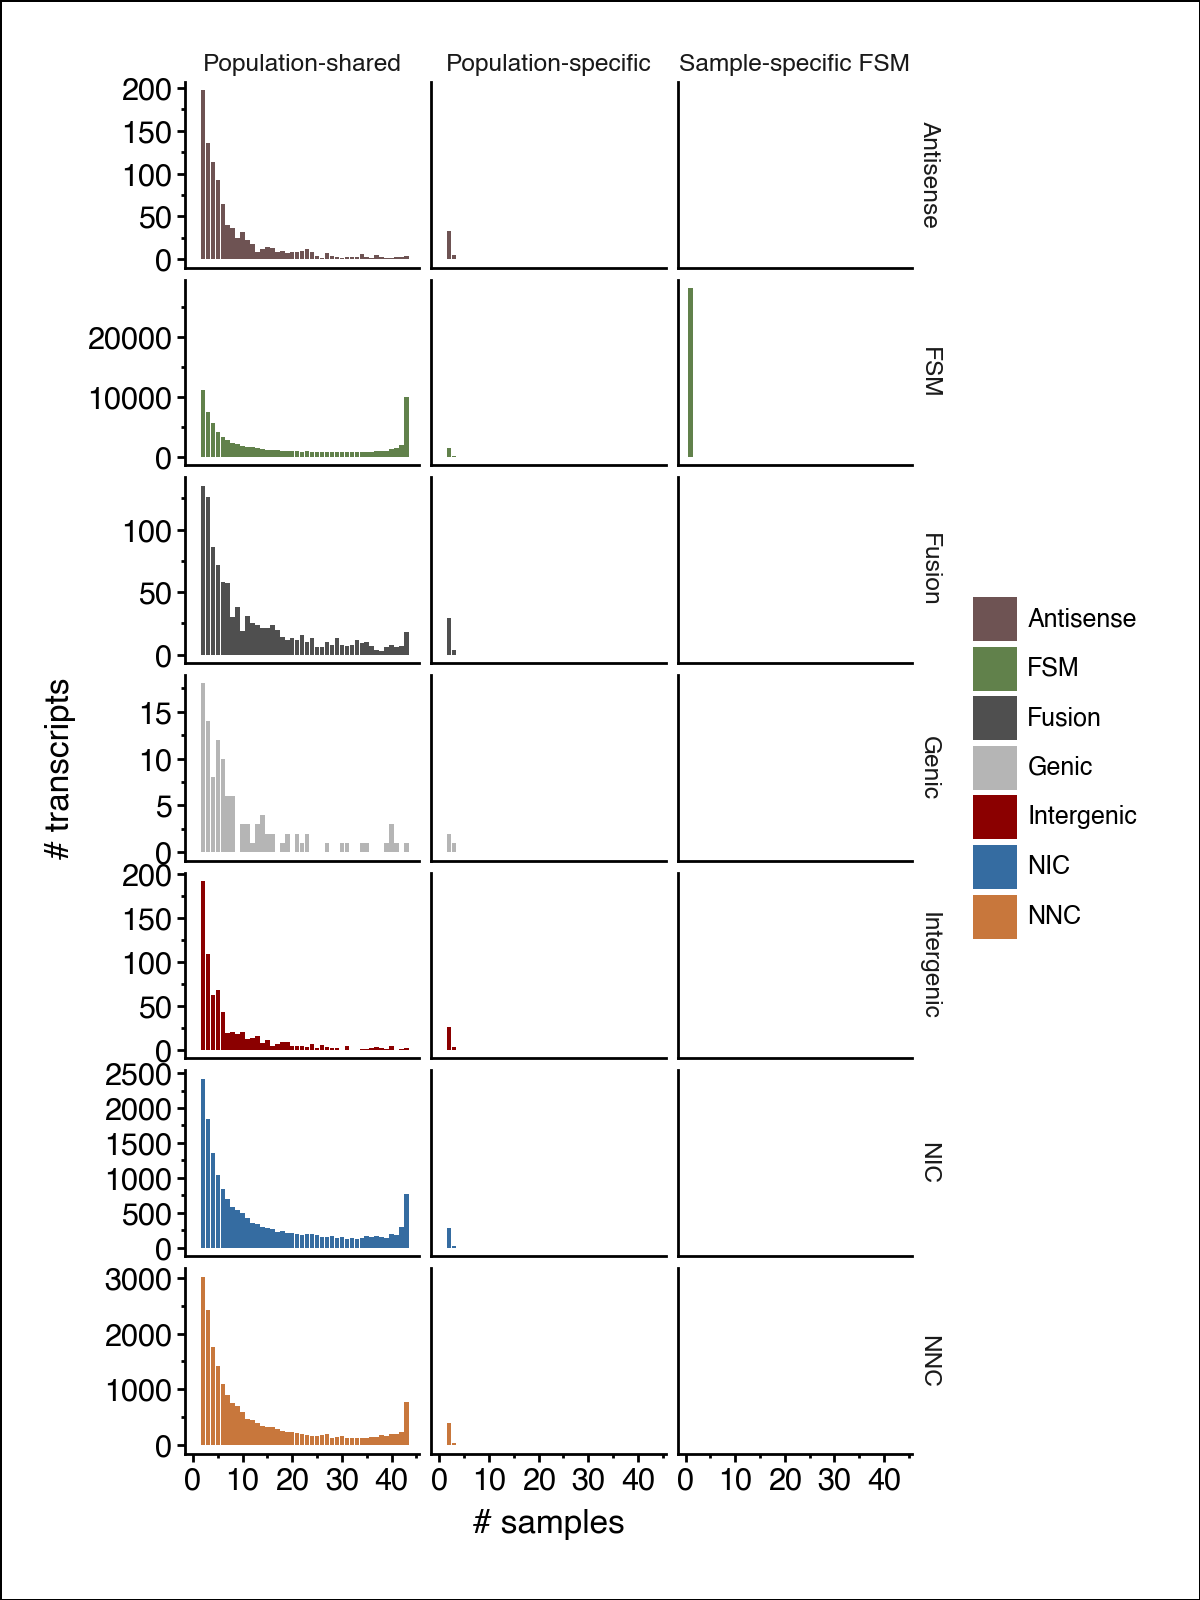

In [51]:
(ggplot(temp, aes(x='sample_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme(w=6, h=8)
        +labs(y='# transcripts',
              x='# samples')
)


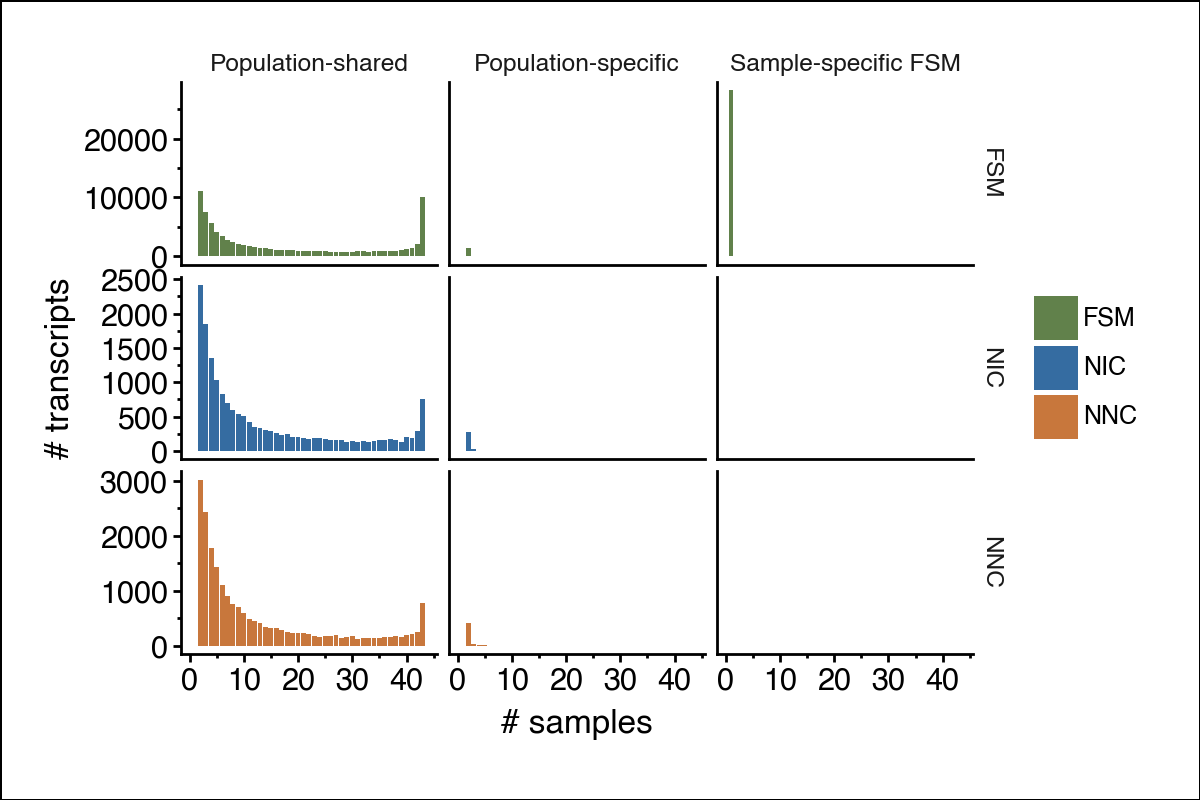

In [52]:
temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]
(ggplot(temp2, aes(x='sample_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme(w=6, h=4)
        +labs(y='# transcripts',
              x='# samples')
)


## What % of transcripts are expressed in 100%, 50%, 25% of samples?

In [72]:
sample_percs = [25, 50, 75, 100]
n_samples = 43
n_sample_threshes = [int((p/100)*n_samples) for p in sample_percs]
n_sample_threshes

big_df = pd.DataFrame()
for min_samples, min_perc in zip(n_sample_threshes, sample_percs):
    temp['over_thresh'] = temp.sample_sharing>=min_samples
    temp['n_t_tot'] = temp[['structural_category', 'n_t']].groupby('structural_category').transform('sum')
    temp['n_t_over_thresh'] = temp[['structural_category', 'over_thresh', 'n_t']].groupby(['structural_category', 'over_thresh']).transform('sum')
    
    temp2 = temp.loc[temp.over_thresh == True]
    temp2.loc[temp2.structural_category=='FSM'].head()
    temp2 = temp2[['cat', 'structural_category', 'n_t_tot', 'n_t_over_thresh']].drop_duplicates()
    temp2['perc'] = (temp2['n_t_over_thresh']/temp2['n_t_tot'])*100
    temp2['min_%_samples'] = min_perc
    
    big_df = pd.concat([big_df, temp2], axis=0)

    

In [73]:
big_df.head()

,cat,structural_category,n_t_tot,n_t_over_thresh,perc,min_%_samples
8,Population-shared,Antisense,1002,258,25.748503,25
50,Population-shared,FSM,114578,45541,39.746723,25
92,Population-shared,Fusion,1066,431,40.431520,25
133,Population-shared,Genic,114,37,32.456140,25
162,Population-shared,Intergenic,731,171,23.392613,25


In [ ]:
(ggplot(temp2, aes(x='min_%_samples', y='perc', fill='structural_category'))
 +scale_fill_manual(
)

## What the hecc

In [15]:
temp.loc[(temp.sample_sharing==1)&(temp.cat=='Population-shared')]

,cat,structural_category,sample_sharing,n_t


In [16]:
pops = get_population_colors()[1]
mt_df['n_pops'] = (mt_df[pops]>0).sum(axis=1)
mt_df['n_samples'] = mt_df[pops].sum(axis=1)

mt_df['pop_sharing_good'] = mt_df.n_pops == mt_df.population_sharing
mt_df[['isoform', 'pop_sharing_good']].groupby('pop_sharing_good').nunique()

,isoform
pop_sharing_good,
True,155875


In [17]:
mt_df.loc[mt_df.pop_sharing_good==False][pops+['population_sharing', 'n_pops', 'n_samples', 'pop_sharing_good']].head()

,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI,population_sharing,n_pops,n_samples,pop_sharing_good


In [18]:
# what are these?
temp = mt_df.loc[mt_df.pop_sharing_good==False]

In [19]:
temp[['isoform', 'pop_spec_t']].groupby('pop_spec_t').nunique()

,isoform
pop_spec_t,


In [20]:
temp[['isoform', 'structural_category']].groupby('structural_category').nunique()


,isoform
structural_category,


In [21]:
temp['actually_n_samples'] = temp.population_sharing

In [22]:
temp[['geneid.v']].head()
len(temp['geneid.v'].unique())

0

In [23]:
# how many should have been population specific transcripts
mt_df['pop_spec_t_2'] = (mt_df.n_pops==1)&\
                      (mt_df.sample_sharing>1)

In [24]:
mt_df['bad_pop_spec'] = mt_df.pop_spec_t != mt_df.pop_spec_t_2

In [25]:
mt_df[['isoform', 'bad_pop_spec', 'structural_category']].groupby(['bad_pop_spec', 'structural_category']).nunique()

isoform
bad_pop_spec structural_category         
False        Antisense               1002
             FSM                   114578
             Fusion                  1066
             Genic                    114
             Intergenic               731
             NIC                    17425
             NNC                    20959

In [26]:
mt_df[['isoform', 'bad_pop_spec', 'det_pop']].groupby(['bad_pop_spec', 'det_pop']).nunique()

isoform
bad_pop_spec det_pop         
False        AJI        53711
             CEU        19109
             HAC        31066
             ITU        11117
             LWK         9847
             MPC         6593
             PEL        14526
             YRI         9906

## Of the population-shared transcripts, what other populations do they occur in ? 

In [27]:
df = mt_df.loc[mt_df.cat == 'Population-shared']

pops = get_population_colors()[1]
df = df[['isoform']+pops]
df.set_index('isoform', inplace=True)

# make sure no things only in one sample are in here 
df['thing'] = df.sum(axis=1)
assert len(df.loc[df.thing==1].index) == 0
df = df.drop('thing', axis=1)

In [28]:
# make sure no things only in one population are in here,
# because they should belong to the population-specific transcripts
df = df[pops] > 0
df['thing'] = df.sum(axis=1)
assert len(df.loc[df.thing==1].index) == 0
df = df.drop('thing', axis=1)

In [29]:
df = df.reset_index()
df = df.set_index(pops)

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

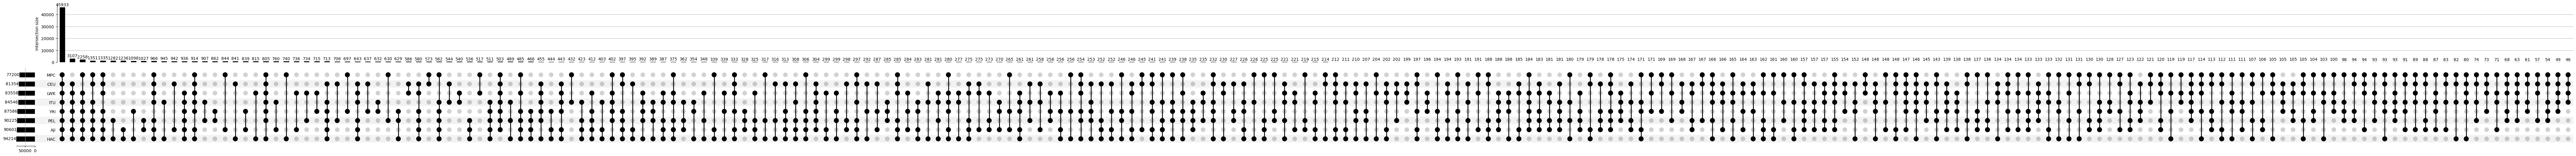

In [30]:
upset = upsetplot.UpSet(df, sort_by='cardinality', show_counts=True)
upset.plot()
plt.show()

## Look at the distribution of different # of populations
ie how many transcripts that are shared are shared between 2 pops? 3 pops? etc.


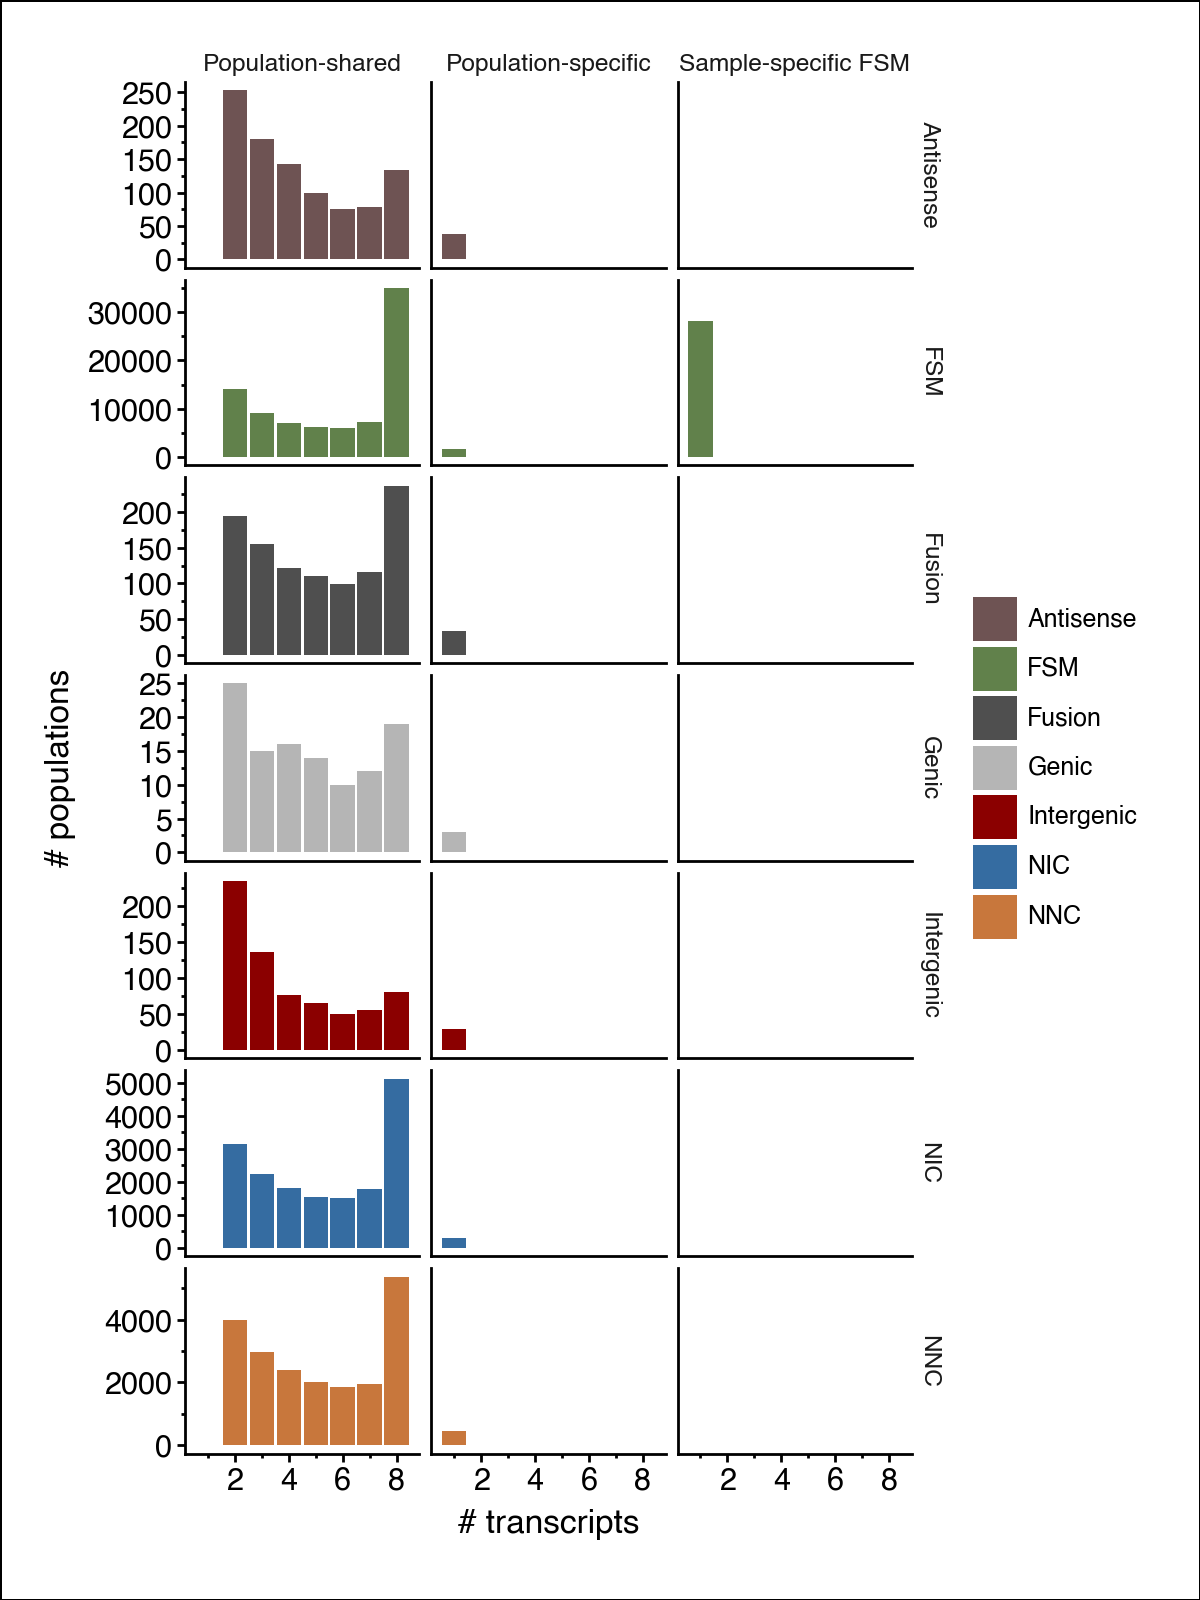

In [31]:
# facet by structural category
df = mt_df[['isoform',
         'cat',
         'structural_category',
         'population_sharing']].groupby(['structural_category', 'cat', 'population_sharing']).nunique().reset_index().rename({'isoform':'n_t'}, axis=1)

(ggplot(df, aes(x='population_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme(w=6, h=8)
        +labs(y='# populations',
              x='# transcripts')
)


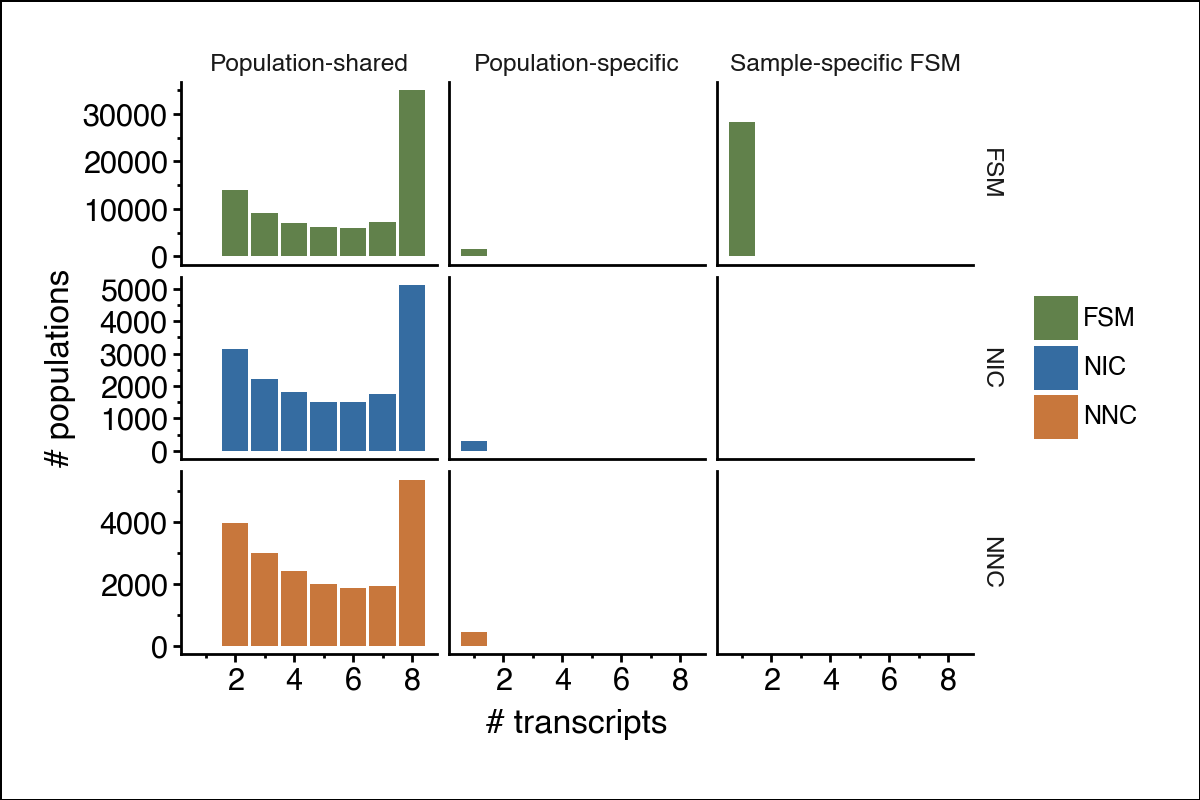

In [32]:
# facet by structural category
# only categories I care about

df = mt_df[['isoform',
         'cat',
         'structural_category',
         'population_sharing']].groupby(['structural_category', 'cat', 'population_sharing']).nunique().reset_index().rename({'isoform':'n_t'}, axis=1)
df = df.loc[df.structural_category.isin(['FSM', 'NIC', 'NNC'])]

(ggplot(df, aes(x='population_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme(w=6, h=4)
        +labs(y='# populations',
              x='# transcripts')
)


In [33]:
# what % of transcripts in each are present in all populations?
df = mt_df.loc[mt_df.cat=='Population-shared']
df['n_total_t'] = df[['isoform', 'structural_category']].groupby('structural_category').transform('nunique')
df['in_all'] = df['population_sharing'] == 8
df['n_t_in_all'] = df[['isoform', 'in_all', 'structural_category']].groupby(['in_all', 'structural_category']).transform('nunique')
df = df[['in_all', 'n_t_in_all', 'structural_category', 'n_total_t']].drop_duplicates()

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_40690/3805414361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_40690/3805414361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_40690/3805414361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [34]:
df['perc'] = (df['n_t_in_all']/df['n_total_t'])*100
df.loc[df.in_all==True]

,in_all,n_t_in_all,structural_category,n_total_t,perc
44,True,5366,NNC,20516,26.155196
55,True,34978,FSM,84793,41.251047
435,True,237,Fusion,1033,22.942885
1939,True,5118,NIC,17120,29.894860
2329,True,134,Antisense,964,13.900415
2446,True,81,Intergenic,702,11.538462
13644,True,19,Genic,111,17.117117


In [ ]:
# what % of transcripts in each are present in all populations?
df = mt_df.loc[mt_df.cat=='Population-shared']
df['n_total_t'] = df[['isoform', 'structural_category']].groupby('structural_category').transform('nunique')
df['in_all'] = df['population_sharing'] == 8
df['n_t_in_all'] = df[['isoform', 'in_all', 'structural_category']].groupby(['in_all', 'structural_category']).transform('nunique')
df = df[['in_all', 'n_t_in_all', 'structural_category', 'n_total_t']].drop_duplicates()